In [1]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('../data/uppsala_tm_1722-2022/uppsala_tm_1722-2022.dat', sep=r'\s+', )
df.columns = ['year', 'month', 'day', 'temp', 'temp_corrected', 'data_source']

In [3]:
df

,year,month,day,temp,temp_corrected,data_source
0,1722,1,13,2.3,2.2,1
1,1722,1,14,1.8,1.7,1
2,1722,1,15,0.9,0.8,1
3,1722,1,16,-1.8,-1.9,1
4,1722,1,17,0.5,0.4,1
...,...,...,...,...,...,...
109921,2022,12,27,0.1,-0.2,1
109922,2022,12,28,-4.1,-4.4,1
109923,2022,12,29,2.8,2.6,1
109924,2022,12,30,4.2,4.0,1


In [4]:
monthly_temp = df.groupby(['year', 'month'])['temp'].mean()
monthly_temp = monthly_temp[:]
train = monthly_temp[:-60].copy()
test = monthly_temp[-60:].copy()
## Initialise the model

## Define the time interval for fitting the data
t_data = np.arange(monthly_temp.index.shape[0])
t_data_train = t_data[:train.index.shape[0]]
t_data_test = t_data[train.index.shape[0]:]

seasons = 12
lags = 1
priors = {
    "coefs_ar": {"mu": [0 for i in range(lags + 1)], "sigma": [1 for i in range(lags + 1)], "size": lags + 1},
    "sigma_ar":2,
    "sigma": 2,
    "init_ar": {"mu": 1.2, "sigma": 1, "size": lags + 1},
    "init_seasonality": {"mu": 0, "sigma": 1, "size":seasons - 1},
    "sigma_seasonality": 1
}


<Axes: title={'center': 'Daily Mean Temperature'}, xlabel='year,month'>

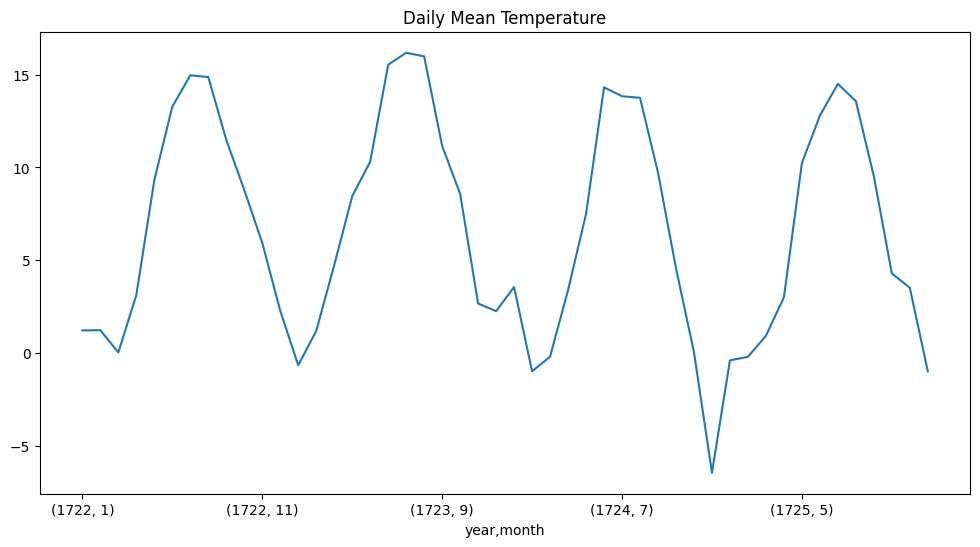

In [5]:
monthly_temp[:12 *4 ].plot(figsize=(12, 6), title='Daily Mean Temperature')


In [6]:
## Set up a dictionary for the specification of our priors
## We set up the dictionary to specify size of the AR coefficients in
## case we want to vary the AR lags.

with pm.Model() as AR:
    pass
## Add the time interval as a mutable coordinate to the model to allow for future predictions
AR.add_coord("obs_id", t_data_train)

with AR:
    ## Data containers to enable prediction
    t = pm.Data("t", t_data_train, dims="obs_id")
    y = pm.Data("y", train, dims="obs_id")

    # The first coefficient will be the constant term but we need to set priors for each coefficient in the AR process
    coefs = pm.Normal("coefs", priors["coefs_ar"]["mu"], priors["coefs_ar"]["sigma"])
    sigma = pm.HalfNormal("sigma", priors["sigma"])
    sigma_ar = pm.HalfNormal("sigma_ar", priors["sigma_ar"])
    sigma_seasonality = pm.HalfNormal("sigma_seasonality", priors["sigma_seasonality"])
    # We need one init variable for each lag, hence size is variable too
    init_ar = pm.Normal.dist(
        priors["init_ar"]["mu"], priors["init_ar"]["sigma"], size=priors["init_ar"]["size"] - 1
    )
    # Steps of the AR model minus the lags required
    ar2 = pm.AR(
        "ar",
        coefs,
        sigma=sigma_ar,
        init_dist=init_ar,
        constant=True,
        steps=t.shape[0] - (priors["coefs_ar"]["size"] - 1),
        dims="obs_id",
    )
    init_seasonality = pm.Normal.dist(
        mu=priors['init_seasonality']['mu'], sigma=priors['init_seasonality']['sigma'], size=priors['init_seasonality']['size']
    )
    seasonality_coefs = np.full(shape=priors["init_seasonality"]['size'], fill_value=-1)
    # The Fourier terms are added to the AR process
    # We need to set the size of the Fourier terms to be the number of coefficients
    seasonality = pm.AR(
        "seasonality",
        seasonality_coefs,
        sigma=sigma_seasonality,
        init_dist=init_seasonality,
        constant=False,
        steps=t.shape[0] - (seasons - 1),
        dims="obs_id",
    )

    # The Likelihood
    outcome = pm.Normal("likelihood", mu=ar2 + seasonality, sigma=sigma, observed=y, dims="obs_id")
    ## Sampling
    # idata_ar = pm.sample_prior_predictive(draws=10)
    idata_ar = pm.sample(1000, tune=1000, chains=4)
    idata_ar.extend(pm.sample_posterior_predictive(idata_ar))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coefs, sigma, sigma_ar, sigma_seasonality, ar, seasonality]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 581 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [likelihood]


Output()

<Axes: xlabel='likelihood'>

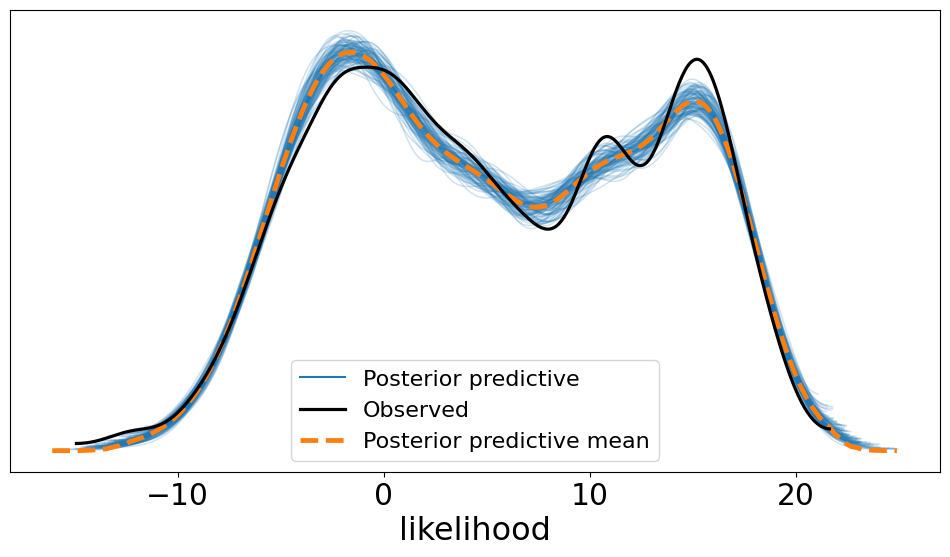

In [7]:
az.plot_ppc(idata_ar, num_pp_samples=100, figsize=(12, 6))

In [8]:
az.summary(idata_ar, var_names=["coefs"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],2.361,0.190,2.000,2.713,0.015,0.006,175.0,458.0,1.03
coefs[1],0.568,0.035,0.502,0.630,0.003,0.001,170.0,409.0,1.03


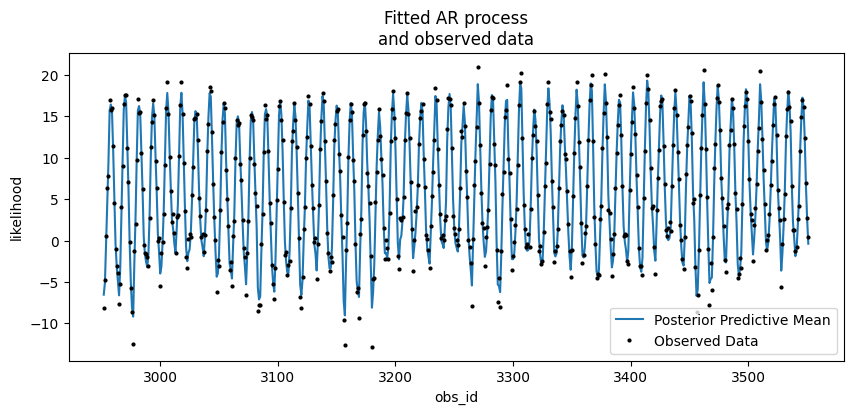

In [118]:
fig, ax = plt.subplots(figsize=(10, 4))
idata_ar.posterior_predictive.likelihood.mean(["chain", "draw"])[-50*12:].plot(ax=ax, label="Posterior Predictive Mean")
ax.plot(t_data_train[-50 * 12:], train.values[-50 * 12:], "o", color="black", markersize=2, label="Observed Data")
ax.legend()
ax.set_title("Fitted AR process\nand observed data");

In [86]:
az.summary(idata_ar,var_names=['coefs'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],1.407,0.076,1.262,1.546,0.001,0.001,3097.0,2969.0,1.0
coefs[1],0.743,0.013,0.718,0.768,0.000,0.000,2957.0,3215.0,1.0


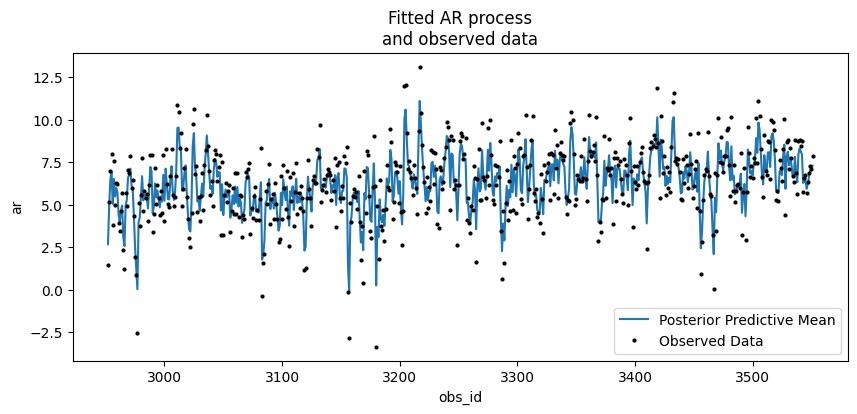

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
idata_ar.posterior.ar.mean(['chain','draw'])[-50*12:].plot(ax=ax, label="Posterior Predictive Mean")
ax.plot(t_data_train[-50 * 12:], train.values[-50 * 12:] - idata_ar.posterior.seasonality.mean(["chain", "draw"])[-50*12:], "o", color="black", markersize=2, label="Observed Data")
ax.legend()
ax.set_title("Fitted AR process\nand observed data");

In [10]:
with AR:
    ## We need to have coords for the observations minus the lagged term to correctly centre the prediction step
    AR.add_coords({"obs_id_fut_ar": np.concatenate([t_data_train[-lags:], t_data_test])})
    AR.add_coords({"obs_id_fut_seasonality": np.concatenate([t_data_train[-seasons+1:], t_data_test])})
    AR.add_coords({"obs_id_fut": t_data_test})
    # condition on the learned values of the AR process
    # initialise the future AR process precisely at the last observed value in the AR process
    # using the special feature of the dirac delta distribution to be 0 everywhere else.

In [11]:

with AR:
    init_ar_fut = pm.DiracDelta.dist(ar2[...,-lags:])
    ar_fut = pm.AR(
        "ar_fut",
        init_dist=init_ar_fut,
        rho=coefs,
        sigma=sigma,
        constant=True,
        dims="obs_id_fut_ar"
    )
    init_seasonality_fut = pm.DiracDelta.dist(seasonality[...,-seasons+1:])
    seasonality_fut = pm.AR(
        "seasonality_fut",
        init_dist=init_seasonality_fut,
        rho=seasonality_coefs,
        sigma=sigma,
        constant=False,
        dims="obs_id_fut_seasonality"
    )
    yhat_fut = pm.Normal("yhat_fut", mu= ar_fut[lags:] + seasonality_fut[seasons - 1:], sigma=sigma, dims="obs_id_fut")
    # use the updated values and predict outcomes and probabilities:
    idata_preds = pm.sample_posterior_predictive(
        idata_ar, var_names=["yhat_fut"], predictions=True
    )


Sampling: [ar_fut, seasonality_fut, yhat_fut]


Output()

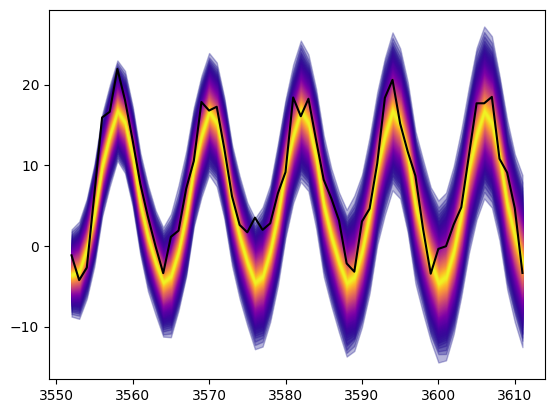

In [13]:
# idata_preds.predictions.yhat_fut[0].to_pandas().T.plot(alpha=0.01, color="y", legend=False)
# idata_preds.predictions.yhat_fut.mean(['chain', 'draw']).plot(color="red")

percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))

palette = "plasma"
cmap = plt.get_cmap(palette)

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(
        idata_preds.predictions.yhat_fut, p, axis=[0, 1]
    )
    lower = np.percentile(
        idata_preds.predictions.yhat_fut, 100 - p, axis=[0, 1]
    )
    color_val = colors[i]

    plt.fill_between(
        x=idata_preds.predictions.coords["obs_id_fut"].data,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.3,
    )
plt.plot(t_data_test, test.values, label="Observed Data", color='black')

<Axes: xlabel='year,month'>

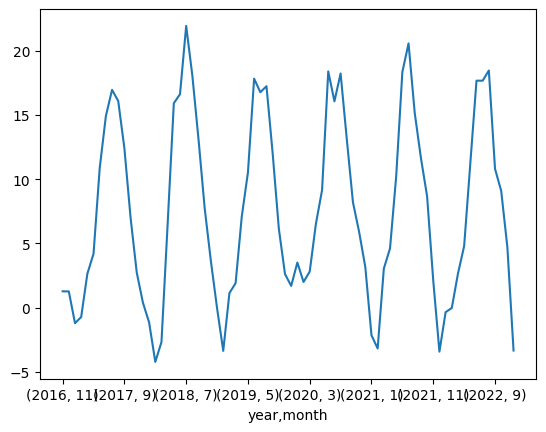

In [69]:
monthly_temp[3538:].plot()